In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
        transforms.RandomErasing(p=0.75,
                                 scale=(0.01, 0.3),
                                 ratio=(1.0, 1.0),
                                 value=0,
                                 inplace =True)
    ])

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=3
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
from torchsummary import summary

# Load the pretrained VGG16 model
vgg16 = models.vgg16()
f_extractor = vgg16.features

model = nn.Sequential(f_extractor, 
                      nn.Flatten(), 
                      nn.Dropout(), 
                      nn.Linear(512, 10))
model.to(device)
summary(model, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─ReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-4                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-6                       [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-7                         [-1, 128, 16, 16]         --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         147,584
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 8, 8]           --
|    └─Conv2d: 2-11                      [-1, 256, 8, 8]           295,168
|    └─ReLU: 2-12                        [-1, 256, 8, 8]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─ReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-4                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-6                       [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-7                         [-1, 128, 16, 16]         --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         147,584
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 8, 8]           --
|    └─Conv2d: 2-11                      [-1, 256, 8, 8]           295,168
|    └─ReLU: 2-12                        [-1, 256, 8, 8]        

# Train

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=5e-4)  

In [5]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [6]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 100

In [7]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/100], Loss: 1.9045, Accuracy: 25.59%, Test Loss: 1.5437, Test Accuracy: 40.87%
Epoch [2/100], Loss: 1.4597, Accuracy: 45.21%, Test Loss: 1.2622, Test Accuracy: 54.46%
Epoch [3/100], Loss: 1.1918, Accuracy: 56.76%, Test Loss: 1.0863, Test Accuracy: 61.74%
Epoch [4/100], Loss: 1.0150, Accuracy: 63.88%, Test Loss: 0.8985, Test Accuracy: 68.80%
Epoch [5/100], Loss: 0.8826, Accuracy: 68.82%, Test Loss: 0.8687, Test Accuracy: 70.31%
Epoch [6/100], Loss: 0.7797, Accuracy: 72.93%, Test Loss: 0.7961, Test Accuracy: 72.76%
Epoch [7/100], Loss: 0.6957, Accuracy: 75.89%, Test Loss: 0.7299, Test Accuracy: 75.65%
Epoch [8/100], Loss: 0.6377, Accuracy: 78.13%, Test Loss: 0.6801, Test Accuracy: 77.63%
Epoch [9/100], Loss: 0.5533, Accuracy: 81.01%, Test Loss: 0.6590, Test Accuracy: 78.58%
Epoch [10/100], Loss: 0.5043, Accuracy: 82.73%, Test Loss: 0.6730, Test Accuracy: 78.39%
Epoch [11/100], Loss: 0.4539, Accuracy: 84.49%, Test Loss: 0.6718, Test Accuracy: 79.80%
Epoch [12/100], Loss: 0.4059, 

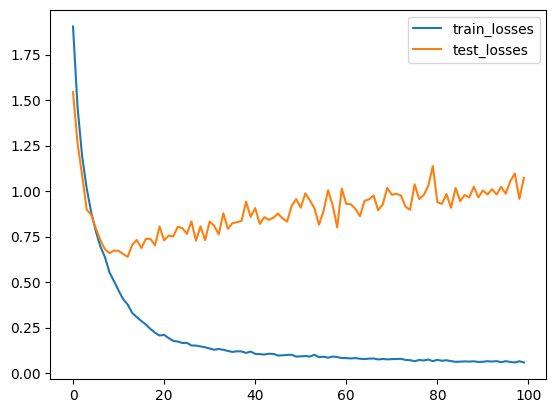

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

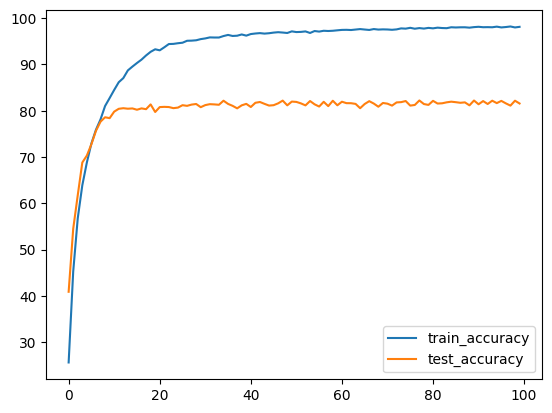

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [10]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

In [11]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()